In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_csv('India_Elec_data_(Jan2020-Mar2025).csv')

In [3]:
data.describe()

,Max Demand Met,Shortage During Peak,Energy Met,Drawl Schedule,OD(+) / UD(-),Max OD,Energy Shortage
count,62972.000000,64006.000000,64014.000000,64024.000000,64024.000000,64020.000000,64024.000000
mean,5914.468621,31.847999,118.034654,53.667034,0.047723,283.421821,1.251784
std,6572.822893,175.700777,135.339533,63.055726,6.855528,301.096262,9.975461
min,36.000000,-75.000000,0.000000,-1415.000000,-908.000000,-1065.000000,-43.800000
25%,358.000000,0.000000,6.600000,4.700000,-0.800000,45.000000,0.000000
50%,3452.000000,0.000000,69.100000,30.200000,-0.100000,200.000000,0.000000
75%,9666.250000,0.000000,194.400000,86.300000,0.300000,438.000000,0.000000
max,30675.000000,3311.000000,685.000000,1502.000000,66.300000,15623.000000,1153.000000


In [4]:
data["Date"] = pd.to_datetime(data["Date"], errors="coerce")

In [5]:
STATE = "Andhra Pradesh"
df = data[data["State"] == STATE].copy()

In [6]:
df = df.dropna(subset=["Drawl Schedule", "OD(+) / UD(-)"])

In [7]:
df["Actual_Drawl"] = df["Drawl Schedule"] + df["OD(+) / UD(-)"]

In [8]:
df = df.sort_values("Date").reset_index(drop=True)

**Correlation between drawl and actual drawn**

In [9]:
corr = df["Drawl Schedule"].corr(df["Actual_Drawl"])
print("Correlation (S_t, A_t):", corr)

Correlation (S_t, A_t): 0.9972094125053577


Error 

In [10]:
df["Error"] = df["Actual_Drawl"] - df["Drawl Schedule"]

error_stats = {
    "mean_error": df["Error"].mean(),
    "std_error": df["Error"].std(),
    "max_overdraw": df["Error"].max(),
    "max_underdraw": df["Error"].min()
}

print(error_stats)

{'mean_error': np.float64(0.037566702241195356), 'std_error': 1.627138258741535, 'max_overdraw': 21.799999999999997, 'max_underdraw': -8.0}


**Relational Error , Error / Predicted Drawl**

In [11]:
df["Rel_OD"] = df["Error"] / df["Drawl Schedule"]

rel_stats = {
    "mean_rel_od": df["Rel_OD"].mean(),
    "std_rel_od": df["Rel_OD"].std(),
    "max_rel_od": df["Rel_OD"].max(),
    "min_rel_od": df["Rel_OD"].min()
}

print(rel_stats)

{'mean_rel_od': np.float64(-inf), 'std_rel_od': nan, 'max_rel_od': 5.0, 'min_rel_od': np.float64(-inf)}


**Rolling OD -  Mistakes do they stay or move on**

In [12]:
WINDOW = 100  # days

df["OD_roll_mean"] = df["Error"].rolling(WINDOW).mean()
df["OD_roll_std"]  = df["Error"].rolling(WINDOW).std()

In [13]:
for lag in [1, 2, 3, 7]:
    df[f"OD_lag_{lag}"] = df["Error"].shift(lag)
    corr_lag = df[f"OD_lag_{lag}"].corr(df["Actual_Drawl"])
    print(f"Corr(OD_t-{lag}, A_t): {corr_lag}")

Corr(OD_t-1, A_t): 0.2764334845350078
Corr(OD_t-2, A_t): 0.2336037361346498
Corr(OD_t-3, A_t): 0.19137349506160423
Corr(OD_t-7, A_t): 0.11861216228691987


In [14]:
from sklearn.linear_model import LinearRegression

X = df[["Drawl Schedule"]]
y = df["Actual_Drawl"]

model = LinearRegression()
model.fit(X, y)

print("Slope:", model.coef_[0])
print("Intercept:", model.intercept_)
print("R^2:", model.score(X, y))

Slope: 1.0156041826865632
Intercept: -1.0706266980158006
R^2: 0.9944266123892803


**A Summation of this but for all the states and considering the mean**

In [15]:
df = pd.read_csv("India_Elec_data_(Jan2020-Mar2025).csv")

In [16]:
df["Date"] = pd.to_datetime(df["Date"], errors="coerce")

# Drop rows needed for drawl logic
df = df.dropna(subset=["Drawl Schedule", "OD(+) / UD(-)"])

# Actual Drawl
df["Actual_Drawl"] = df["Drawl Schedule"] + df["OD(+) / UD(-)"]

# Error (OD)
df["Error"] = df["Actual_Drawl"] - df["Drawl Schedule"]

# Relative OD 
df["Rel_OD"] = np.where(
    df["Drawl Schedule"] != 0,
    df["Error"] / df["Drawl Schedule"],
    np.nan
)


In [17]:
state_summary = (
    df.groupby("State")
      .agg(
          mean_scheduled_drawl=("Drawl Schedule", "mean"),
          mean_actual_drawl=("Actual_Drawl", "mean"),
          mean_error=("Error", "mean"),
          std_error=("Error", "std"),
          mean_rel_od=("Rel_OD", "mean"),
          std_rel_od=("Rel_OD", "std"),
          observations=("Error", "count")
      )
      .reset_index()
)

In [18]:
corr_list = []

for state, sdf in df.groupby("State"):
    if len(sdf) > 30:
        corr = sdf["Drawl Schedule"].corr(sdf["Actual_Drawl"])
        corr_list.append({"State": state, "corr_S_A": corr})

corr_df = pd.DataFrame(corr_list)

# Merge correlation into summary
state_summary = state_summary.merge(corr_df, on="State", how="left")

# Sort by predictability
state_summary = state_summary.sort_values(
    by="corr_S_A", ascending=False
).reset_index(drop=True)

print(state_summary)

                   State  mean_scheduled_drawl  mean_actual_drawl  mean_error  \
0                     HP             15.128368          14.963895   -0.164474   
1              Telangana             96.218220          96.202754   -0.015466   
2                 Punjab             95.984958          94.842055   -1.142903   
3                  NR UP            151.738030         151.068273   -0.669756   
4                     MP            143.355427         141.176291   -2.179136   
5            West Bengal             40.578549          39.756777   -0.821772   
6                     DD              2.462153          -0.106597   -2.568750   
7           SR Karnataka             72.663289          72.278462   -0.384828   
8                  Delhi             79.746928          78.663347   -1.083581   
9                 Kerala             54.513983          54.905350    0.391367   
10               Haryana            114.984799         114.604131   -0.380667   
11               Gujarat    

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Load the Master Database
# Use the file you just generated (either _FIXED or the normal one)
file_path = 'Master_Weather_Electricity_Data_FIXED.csv' 
print(f"Loading {file_path} for Feature Selection...")
df = pd.read_csv(file_path)

Loading Master_Weather_Electricity_Data_FIXED.csv for Feature Selection...


In [2]:
# 2. Prepare Data
# Ensure we have the target 'Gap' (Actual - Schedule)
# We fill NaNs with 0 to ensure correlations don't break, though dropping is often better
df['Drawl_Schedule'] = pd.to_numeric(df['Drawl_Schedule'], errors='coerce').fillna(0)
df['Actual_Drawl'] = pd.to_numeric(df['Actual_Drawl'], errors='coerce').fillna(0)
df['Gap'] = df['Actual_Drawl'] - df['Drawl_Schedule']

# Identify all Weather Columns (Open-Meteo & NASA)
weather_cols = [c for c in df.columns if c.startswith('om_') or c.startswith('nasa_')]
print(f"Analyzing {len(weather_cols)} weather variables: {weather_cols}")

Analyzing 12 weather variables: ['om_temp_mean', 'om_temp_max', 'om_dewpoint', 'om_humidity', 'om_wind_speed', 'om_wind_gusts', 'om_precip', 'om_solar', 'nasa_temp_max', 'nasa_humidity', 'nasa_solar', 'nasa_precip']


In [3]:
# 3. CALCULATE CORRELATIONS
results = {}

for state in df['State'].unique():
    state_data = df[df['State'] == state]
    
    # We need enough data points to run a correlation
    if len(state_data) > 50:
        # Calculate correlation of all weather cols against 'Gap'
        # We use .corrwith() to do it in one shot against the target series
        corrs = state_data[weather_cols].corrwith(state_data['Gap'])
        results[state] = corrs

In [4]:
# 4. CONVERT TO DATAFRAME
corr_df = pd.DataFrame(results).T # Transpose so States are rows, Weather Vars are columns

# 5. CALCULATE AGGREGATE SCORES (The "Significance")
# We take the ABSOLUTE mean because a strong negative correlation (-0.8) is just as important as positive
avg_scores = corr_df.abs().mean()

# Add the 'AVERAGE_SCORE' row to the bottom of the dataframe
corr_df.loc['AVERAGE_IMPORTANCE'] = avg_scores

# Sort columns by their Global Importance (High to Low)
sorted_cols = avg_scores.sort_values(ascending=False).index
corr_df = corr_df[sorted_cols]

In [5]:
# 6. PRINT RESULTS
print("\n" + "="*80)
print("DETAILED WEATHER IMPACT SCORES (Correlation with Demand Gap)")
print("="*80)
# Print the full table (States x Variables)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
print(corr_df.round(3))

print("\n" + "="*80)
print("FINAL VERDICT: VARIABLE SIGNIFICANCE RANKING")
print("="*80)
print(avg_scores.sort_values(ascending=False).round(4))

# 7. RECOMMENDATION: WHICH TO DROP?
# Define a threshold (e.g., 0.05). If average impact is lower, it's noise.
threshold = 0.05
drop_cols = avg_scores[avg_scores < threshold].index.tolist()
keep_cols = avg_scores[avg_scores >= threshold].index.tolist()

print("\n" + "="*80)
print("RECOMMENDATION")
print("="*80)
print(f"KEEP these columns (Significant Impact): {keep_cols}")
print(f"DROP these columns (Minimal/No Impact): {drop_cols}")


DETAILED WEATHER IMPACT SCORES (Correlation with Demand Gap)
                      om_temp_mean  nasa_solar  om_temp_max  om_precip  om_solar  nasa_precip  nasa_temp_max  om_dewpoint  om_humidity  om_wind_gusts  om_wind_speed  nasa_humidity
Andhra Pradesh               0.140       0.177        0.134     -0.150     0.199       -0.086          0.088        0.027       -0.104         -0.067         -0.140         -0.071
Arunachal Pradesh            0.058       0.105        0.073     -0.143     0.119       -0.053          0.050        0.017       -0.084         -0.010         -0.025         -0.061
Assam                        0.142       0.106        0.129     -0.046     0.103       -0.094          0.107        0.144        0.057         -0.089         -0.140          0.019
Bihar                        0.043       0.118        0.070     -0.087     0.140       -0.071          0.061       -0.046       -0.114         -0.027         -0.057         -0.098
Chandigarh                  -0.034    

In [6]:
import pandas as pd

# 1. Load the fixed master file
file_path = 'Master_Weather_Electricity_Data_FIXED.csv' 
# (Or 'Master_Weather_Electricity_Data.csv' if you didn't need the patch)
df = pd.read_csv(file_path)

# 2. Select ONLY the Champions (The variables with the highest scores)
# We also keep the core columns: Date, State, Drawl info
columns_to_keep = [
    'Date', 
    'State', 
    'Actual_Drawl', 
    'Drawl_Schedule', 
    'Gap',            # The target we are analyzing
    'om_temp_mean',   # The Best Temp Metric
    'nasa_solar',     # The Best Solar Metric
    'om_precip',      # The Best Rain Metric
    'om_dewpoint',    # The Best Humidity Metric (Dewpoint combines heat + humidity)
    'om_wind_gusts'   # The Best Wind Metric
]

# 3. Create the Final Model-Ready Dataset
final_df = df[columns_to_keep].copy()

# 4. Save it
final_df.to_csv('Final_Model_Data.csv', index=False)

print("---------------------------------------------------")
print("DATA CLEANING COMPLETE")
print("---------------------------------------------------")
print(f"Original Columns: {len(df.columns)}")
print(f"Final Columns:    {len(final_df.columns)}")
print("Saved as: 'Final_Model_Data.csv'")
print("You are now ready to run the prediction model.")

---------------------------------------------------
DATA CLEANING COMPLETE
---------------------------------------------------
Original Columns: 23
Final Columns:    10
Saved as: 'Final_Model_Data.csv'
You are now ready to run the prediction model.


In [7]:
import pandas as pd

# 1. Load the Data
file_path = 'Final_Model_Data.csv' 
# (Or 'Master_Weather_Electricity_Data.csv' if you haven't filtered features yet)
df = pd.read_csv(file_path)

print(f"Original Shape: {df.shape} (Rows, Cols)")

# ==================================================
# PART A: THE NULL REPORT
# ==================================================
print("\n--- NULL REPORT (Missing Values %) ---")
null_counts = df.isnull().sum()
null_percent = (df.isnull().sum() / len(df)) * 100

# Create a readable table
null_df = pd.DataFrame({'Missing_Rows': null_counts, 'Percent_Missing': null_percent})
print(null_df[null_df['Missing_Rows'] > 0].sort_values('Percent_Missing', ascending=False))

# ==================================================
# PART B: THE CLEAN UP STRATEGY
# ==================================================
# Rule 1: Drop COLUMNS that are more than 30% empty (Too much missing info)
threshold_col = 30 # Percentage
cols_to_drop = null_percent[null_percent > threshold_col].index.tolist()

if cols_to_drop:
    print(f"\n[ACTION] Dropping {len(cols_to_drop)} columns (> {threshold_col}% missing):")
    print(cols_to_drop)
    df = df.drop(columns=cols_to_drop)
else:
    print(f"\n[ACTION] No columns exceeded the {threshold_col}% missing threshold.")

# Rule 2: Drop ROWS for whatever small missing data is left
# (e.g. if one day is missing temp, we can't train on it)
rows_before = len(df)
df = df.dropna()
rows_after = len(df)
lost_rows = rows_before - rows_after

print(f"\n[ACTION] Dropped {lost_rows} rows containing NaNs.")

# ==================================================
# PART C: FINAL SAVE
# ==================================================
print(f"\nFinal Clean Shape: {df.shape}")
df.to_csv('Final_Cleaned_Dataset.csv', index=False)
print("Saved as: 'Final_Cleaned_Dataset.csv'")

Original Shape: (69012, 10) (Rows, Cols)

--- NULL REPORT (Missing Values %) ---
               Missing_Rows  Percent_Missing
om_temp_mean           3834         5.555556
om_precip              3834         5.555556
om_dewpoint            3834         5.555556
om_wind_gusts          3834         5.555556
nasa_solar             1917         2.777778

[ACTION] No columns exceeded the 30% missing threshold.

[ACTION] Dropped 5751 rows containing NaNs.

Final Clean Shape: (63261, 10)
Saved as: 'Final_Cleaned_Dataset.csv'


In [8]:
import pandas as pd

# 1. Load the Three Datasets
try:
    df_orig = pd.read_csv('India_Elec_data_(Jan2020-Mar2025).csv')
    df_model = pd.read_csv('Final_Model_Data.csv')       # Before cleaning nulls
    df_clean = pd.read_csv('Final_Cleaned_Dataset.csv')  # After cleaning nulls

    # 2. Get Row Counts
    rows_orig = len(df_orig)
    rows_model = len(df_model)
    rows_clean = len(df_clean)

    # 3. Print the Reduction Report
    print("--- ROW REDUCTION REPORT ---")
    print(f"1. Original Data:       {rows_orig:,} rows")
    print(f"2. After Weather Merge: {rows_model:,} rows (Difference: {rows_model - rows_orig:,})")
    print(f"3. After Cleaning Nulls:{rows_clean:,} rows (Dropped: {rows_model - rows_clean:,} rows)")

    # 4. Calculate Percentage Loss
    total_loss = rows_orig - rows_clean
    loss_pct = (total_loss / rows_orig) * 100
    print("-" * 30)
    print(f"Total Rows Lost: {total_loss:,}")
    print(f"Data Retention:  {100 - loss_pct:.2f}%")
    print("-" * 30)

except FileNotFoundError as e:
    print(f"Error: Could not find one of the files. {e}")

--- ROW REDUCTION REPORT ---
1. Original Data:       69,012 rows
2. After Weather Merge: 69,012 rows (Difference: 0)
3. After Cleaning Nulls:63,261 rows (Dropped: 5,751 rows)
------------------------------
Total Rows Lost: 5,751
Data Retention:  91.67%
------------------------------


Loading Final_Cleaned_Dataset.csv...
Analyzing 63261 rows of data...

CORRELATION REPORT: Weather vs. Actual Demand
               Actual_Drawl
om_temp_mean       0.250033
nasa_solar         0.163484
om_dewpoint        0.067034
om_wind_gusts      0.065690
om_precip         -0.085583

--------------------------------------------------
INTERPRETATION:
High Positive (> 0.6) : Strong Driver (Hotter = More Power)
Negative (< -0.1)     : Inverse Driver (Rain = Less Power)
Near Zero (-0.1 to 0.1): No Impact
--------------------------------------------------


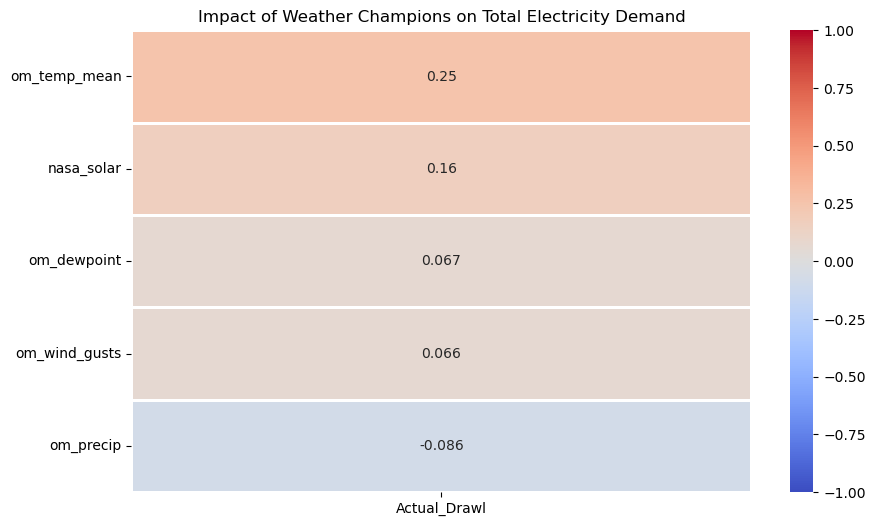

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Load the Final Cleaned Data
file_path = 'Final_Cleaned_Dataset.csv'
print(f"Loading {file_path}...")
df = pd.read_csv(file_path)

# 2. Define the Columns to Analyze
# These are the "Champions" we selected earlier
champion_cols = [
    'om_temp_mean',   # Avg Temperature (The main driver)
    'nasa_solar',     # Solar Radiation
    'om_dewpoint',    # Humidity/Heat Index
    'om_wind_gusts',  # Wind
    'om_precip'       # Rain
]
target = 'Actual_Drawl'  # Total Consumption

# 3. Safety Check: Ensure all columns exist and are numeric
print(f"Analyzing {len(df)} rows of data...")
available_cols = [c for c in champion_cols if c in df.columns]

if not available_cols:
    print("ERROR: Champion columns not found! Check your CSV headers.")
else:
    # Convert to numeric just in case (coercing errors to NaN)
    cols_to_fix = available_cols + [target]
    for col in cols_to_fix:
        df[col] = pd.to_numeric(df[col], errors='coerce')

    # 4. Calculate Correlation
    # We compare every Champion against 'Actual_Drawl'
    correlation_matrix = df[available_cols + [target]].corr()
    
    # Extract just the target column, sorted from highest to lowest
    target_corr = correlation_matrix[[target]].drop(target).sort_values(by=target, ascending=False)

    # 5. Print the Text Report
    print("\n" + "="*50)
    print("CORRELATION REPORT: Weather vs. Actual Demand")
    print("="*50)
    print(target_corr)
    print("\n" + "-"*50)
    print("INTERPRETATION:")
    print("High Positive (> 0.6) : Strong Driver (Hotter = More Power)")
    print("Negative (< -0.1)     : Inverse Driver (Rain = Less Power)")
    print("Near Zero (-0.1 to 0.1): No Impact")
    print("-" * 50)

    # 6. Generate Heatmap Visualization
    plt.figure(figsize=(10, 6))
    sns.heatmap(target_corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1, linewidths=1)
    plt.title('Impact of Weather Champions on Total Electricity Demand')
    plt.show()

In [2]:
import pandas as pd

# Load your data
df = pd.read_csv('Final_Cleaned_Dataset.csv')

# Calculate Correlation PER STATE
# This removes the "Size Difference" problem
state_corrs = df.groupby('State')[['Actual_Drawl', 'om_temp_mean']].corr().iloc[0::2, -1]
print(state_corrs.sort_values(ascending=False))

State                             
West Bengal           Actual_Drawl    0.720188
NR UP                 Actual_Drawl    0.697555
Tripura               Actual_Drawl    0.696167
Punjab                Actual_Drawl    0.668243
Assam                 Actual_Drawl    0.664386
Haryana               Actual_Drawl    0.639047
Bihar                 Actual_Drawl    0.632273
Delhi                 Actual_Drawl    0.628012
Chandigarh            Actual_Drawl    0.566419
Kerala                Actual_Drawl    0.528962
SR Karnataka          Actual_Drawl    0.407682
Puducherry            Actual_Drawl    0.367288
ER Odisha             Actual_Drawl    0.357899
WR Maharashtra        Actual_Drawl    0.349434
Chhattisgarh          Actual_Drawl    0.317302
Goa                   Actual_Drawl    0.259783
Andhra Pradesh        Actual_Drawl    0.232112
Nagaland              Actual_Drawl    0.159303
Telangana             Actual_Drawl    0.143416
DVC                   Actual_Drawl    0.076131
Tamil Nadu            Act

In [3]:
import pandas as pd

# ==========================================
# 1. CONFIGURATION
# ==========================================
file_path = 'Final_Cleaned_Dataset.csv'
target = 'Actual_Drawl'

# The "Champions" we want to test
champions = {
    'om_temp_mean':  'Temperature',
    'nasa_solar':    'Solar Radiation',
    'om_dewpoint':   'Humidity/Dewpoint',
    'om_wind_gusts': 'Wind Gusts',
    'om_precip':     'Rainfall'
}

# ==========================================
# 2. LOAD & CLEAN
# ==========================================
print(f"Loading {file_path}...")
df = pd.read_csv(file_path)

# Ensure numeric
cols = [target] + list(champions.keys())
for col in cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Filter out "Ghost States" (Zero demand or tiny states that break math)
# We keep states with average daily demand > 5 units
state_means = df.groupby('State')[target].mean()
valid_states = state_means[state_means > 5].index.tolist()
df_clean = df[df['State'].isin(valid_states)].copy()

print(f"Analyzing {len(valid_states)} valid states (Dropped ghosts like Essar Steel/Sikkim)")
print("-" * 60)

# ==========================================
# 3. RUN ANALYSIS LOOP
# ==========================================
summary_data = []

for col, name in champions.items():
    print(f"\nAnalyzing Impact of: {name.upper()} ({col})")
    
    # Calculate Correlation Per State
    state_corrs = df_clean.groupby('State')[[target, col]].corr().iloc[0::2, -1].droplevel(1)
    
    # Sort strong to weak
    state_corrs = state_corrs.sort_values(ascending=False)
    
    # 1. Global Average (The "True" Impact Score)
    avg_impact = state_corrs.mean()
    
    # 2. Print Top 3 Most Affected States
    print(f"   > Average State Correlation: {avg_impact:.3f}")
    print(f"   > Top 3 Most Sensitive States:")
    for s, score in state_corrs.head(3).items():
        print(f"     - {s}: {score:.3f}")
        
    # Store for final table
    summary_data.append({
        'Weather_Variable': name,
        'Column': col,
        'Avg_Correlation': avg_impact,
        'Top_State': state_corrs.index[0],
        'Top_Score': state_corrs.iloc[0]
    })

# ==========================================
# 4. FINAL LEADERBOARD
# ==========================================
summary_df = pd.DataFrame(summary_data).sort_values('Avg_Correlation', ascending=False)

print("\n" + "="*60)
print("FINAL CHAMPION LEADERBOARD (State-Wise Average)")
print("="*60)
print(summary_df[['Weather_Variable', 'Avg_Correlation', 'Top_State', 'Top_Score']])
print("\nInterpretation:")
print(" - Avg_Correlation > 0.5: This variable is a MAJOR driver of grid demand.")
print(" - Top_State: The specific state where this weather factor matters most.")

Loading Final_Cleaned_Dataset.csv...
Analyzing 25 valid states (Dropped ghosts like Essar Steel/Sikkim)
------------------------------------------------------------

Analyzing Impact of: TEMPERATURE (om_temp_mean)
   > Average State Correlation: 0.241
   > Top 3 Most Sensitive States:
     - West Bengal: 0.720
     - NR UP: 0.698
     - Punjab: 0.668

Analyzing Impact of: SOLAR RADIATION (nasa_solar)
   > Average State Correlation: 0.143
   > Top 3 Most Sensitive States:
     - SR Karnataka: 0.424
     - Andhra Pradesh: 0.423
     - Tamil Nadu: 0.367

Analyzing Impact of: HUMIDITY/DEWPOINT (om_dewpoint)
   > Average State Correlation: 0.102
   > Top 3 Most Sensitive States:
     - Punjab: 0.784
     - West Bengal: 0.680
     - Assam: 0.661

Analyzing Impact of: WIND GUSTS (om_wind_gusts)
   > Average State Correlation: -0.038
   > Top 3 Most Sensitive States:
     - West Bengal: 0.373
     - NR UP: 0.256
     - Bihar: 0.238

Analyzing Impact of: RAINFALL (om_precip)
   > Average State 